# CICIDS2017 – Intrusion Detection with Benign Undersampling & Grid Search

**Authors:** Sinan HASAN TAWFIQ, Nguyen LE NGUYEN, Jethendiran VELU
**Dataset:** CICIDS2017 – Canadian Institute for Cybersecurity  

This notebook builds an intrusion detection system on CICIDS2017 with:

1. Robust loading and cleaning of multiple CSV files  
2. Strong class imbalance handling by **undersampling the Benign class**  
3. A clean preprocessing pipeline (ColumnTransformer + Pipeline)  
4. Baseline model comparison with cross-validation  
5. Hyperparameter tuning using **GridSearchCV**  
6. Final evaluation and feature importance analysis  



In [1]:
# =====================================
# 1) Imports & global configuration
# =====================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

sns.set_theme()
plt.style.use("default")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_DIR = Path("./data")
print("DATA_DIR:", DATA_DIR.resolve(), "| exists:", DATA_DIR.exists())


DATA_DIR: C:\Users\shasa\Downloads\data | exists: True


In [2]:
# =====================================
# 2) Flexible data loading with per-file sampling
# =====================================

def normalize_columns(df: pd.DataFrame) -> pd.Index:
    """Normalize column names: remove weird spaces and invisible characters."""
    return (
        df.columns
          .str.replace("\xa0", " ", regex=False)
          .str.replace("\u200b", "", regex=False)
          .str.strip()
          .str.replace(r"\s+", " ", regex=True)
    )

def looks_like_cicids(name: str) -> bool:
    n = name.lower()
    return ("workinghours" in n) and ("pcap_iscx" in n)

def load_cicids_flexible(
    data_dir: Path = DATA_DIR,
    samples_per_file: int | None = 120_000,
    random_state: int = 42
) -> pd.DataFrame:
    assert data_dir.exists(), f"Folder not found: {data_dir.resolve()}"
    csvs = sorted([p for p in data_dir.glob("*.csv") if looks_like_cicids(p.name)])
    if not csvs:
        raise FileNotFoundError(f"No CICIDS-like CSVs found in {data_dir.resolve()}")

    print(f"Found {len(csvs)} candidate CSV files:")
    for p in csvs:
        print("  -", p.name)

    rng = np.random.RandomState(random_state)
    dfs = []
    for f in csvs:
        df_part = pd.read_csv(f, low_memory=False)
        df_part.columns = normalize_columns(df_part)
        if samples_per_file is not None and len(df_part) > samples_per_file:
            df_part = df_part.sample(n=samples_per_file, random_state=rng)
        dfs.append(df_part)
        print(f"  -> {f.name:40s} subset shape: {df_part.shape}")

    common = set(dfs[0].columns)
    for d in dfs[1:]:
        common &= set(d.columns)
    if not common:
        raise ValueError("No common columns across CSVs. Please check your files.")

    cols = sorted(common)
    df_all = pd.concat([d[cols].copy() for d in dfs], ignore_index=True)
    print("Concatenated shape:", df_all.shape)
    return df_all

df_raw = load_cicids_flexible(samples_per_file=120_000)
df_raw.head()


Found 8 candidate CSV files:
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv
  -> Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv subset shape: (120000, 79)
  -> Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv subset shape: (120000, 79)
  -> Friday-WorkingHours-Morning.pcap_ISCX.csv subset shape: (120000, 79)
  -> Monday-WorkingHours.pcap_ISCX.csv        subset shape: (120000, 79)
  -> Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv subset shape: (120000, 79)
  -> Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv subset shape: (120000, 79)
  -> Tuesday-WorkingHours.pcap_ISCX.csv       subset shape: (120000, 79)
  -> Wedn

,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,Bwd IAT Max,Bwd IAT Mean,Bwd IAT Min,Bwd IAT Std,Bwd IAT Total,Bwd PSH Flags,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Std,Bwd Packets/s,Bwd URG Flags,CWE Flag Count,Destination Port,Down/Up Ratio,ECE Flag Count,FIN Flag Count,Flow Bytes/s,Flow Duration,Flow IAT Max,Flow IAT Mean,Flow IAT Min,Flow IAT Std,Flow Packets/s,Fwd Avg Bulk Rate,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Header Length,Fwd Header Length.1,Fwd IAT Max,Fwd IAT Mean,Fwd IAT Min,Fwd IAT Std,Fwd IAT Total,Fwd PSH Flags,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Std,Fwd Packets/s,Fwd URG Flags,Idle Max,Idle Mean,Idle Min,Idle Std,Init_Win_bytes_backward,Init_Win_bytes_forward,Label,Max Packet Length,Min Packet Length,PSH Flag Count,Packet Length Mean,Packet Length Std,Packet Length Variance,RST Flag Count,SYN Flag Count,Subflow Bwd Bytes,Subflow Bwd Packets,Subflow Fwd Bytes,Subflow Fwd Packets,Total Backward Packets,Total Fwd Packets,Total Length of Bwd Packets,Total Length of Fwd Packets,URG Flag Count,act_data_pkt_fwd,min_seg_size_forward
0,1,1982,1.982000e+03,1982,0.0000,7.500000,0.000000,6.000000,0,0,0,0,0,0.000000e+00,0,0.000000e+00,0,0,0,0.000000,0,0.000000,0.000000,0,0,80,0,0,0,2.555125e+00,9392887,9390905,3.130962e+06,975,5.421269e+06,0.425854,0,0,0,80,80,9390905,3.130962e+06,975,5.421269e+06,9392887,0,6,6.000000,6,0.000000,0.425854,0,9390905,9390905.0,9390905,0.0000,-1,256,DDoS,6,6,0,6.000000,0.000000,0.000000e+00,0,0,0,0,24,4,0,4,0,24,0,3,20
1,1,27151,2.715100e+04,27151,0.0000,7.000000,6.000000,6.000000,0,0,0,100,5410860,1.355718e+06,3,2.703434e+06,5422871,0,6,6.000000,6,0.000000,0.919454,0,0,64007,5,0,0,6.620068e+00,5438011,5410860,1.087602e+06,3,2.416784e+06,1.103345,0,0,0,20,20,0,0.000000e+00,0,0.000000e+00,0,0,6,6.000000,6,0.000000,0.183891,0,5410860,5410860.0,5410860,0.0000,0,229,BENIGN,6,6,0,6.000000,0.000000,0.000000e+00,0,0,30,5,6,1,5,1,30,6,1,0,20
2,0,566475,1.609163e+05,120118,134508.6864,148.314286,230.866667,86.400000,0,0,0,488,10200000,8.061410e+06,121410,4.296214e+06,113000000,0,1734,230.866667,0,514.538471,0.129740,0,0,80,0,0,0,4.489878e+01,115615609,10100000,3.400459e+06,17,4.722346e+06,0.302727,0,0,0,648,648,10200000,6.085032e+06,118,5.002940e+06,116000000,0,578,86.400000,0,211.017934,0.172987,0,10100000,10100000.0,9988018,46752.4843,255,29200,BENIGN,1734,0,1,144.194444,368.503446,1.357948e+05,0,0,3463,15,1728,20,15,20,3463,1728,0,3,32
3,0,0,0.000000e+00,0,0.0000,1453.375000,2320.200000,8.666667,0,0,0,112,8150,2.445000e+03,190,3.835651e+03,9780,0,7300,2320.200000,0,3022.508098,508.802279,0,0,80,1,0,0,1.183169e+06,9827,7954,1.403857e+03,4,2.919354e+03,814.083647,0,0,0,72,72,8001,4.002500e+03,4,5.654733e+03,8005,0,20,8.666667,0,10.263203,305.281368,0,0,0.0,0,0.0000,229,8192,DDoS,7300,0,1,1291.888889,2460.652985,6.054813e+06,0,0,11601,5,26,3,5,3,11601,26,0,2,20
4,1,4219842,4.219842e+06,4219842,0.0000,729.687500,6.888889,1658.142857,0,0,0,192,82600000,1.090000e+07,0,2.900000e+07,86900000,0,20,6.888889,0,5.301991,0.102759,0,0,53315,1,0,0,1.332331e+02,87583370,82600000,5.838891e+06,0,2.130000e+07,0.182683,0,0,0,152,152,86800000,1.460000e+07,49,3.540000e+07,87600000,0,4380,1658.142857,0,1762.272815,0.079924,0,82600000,82600000.0,82600000,0.0000,256,229,BENIGN,4380,0,0,686.764706,1366.162670,1.866400e+06,0,0,62,9,11607,7,9,7,62,11607,1,5,20


Detected label column: 'Label'
Shape: (960000, 79)


,label,count,ratio
0,BENIGN,775096,0.807392
1,DDoS,68025,0.070859
2,PortScan,66709,0.069489
3,DoS Hulk,40014,0.041681
4,FTP-Patator,2121,0.002209
5,DoS GoldenEye,1796,0.001871
6,SSH-Patator,1588,0.001654
7,Bot,1231,0.001282
8,Web Attack � Brute Force,1028,0.001071
9,DoS slowloris,1007,0.001049


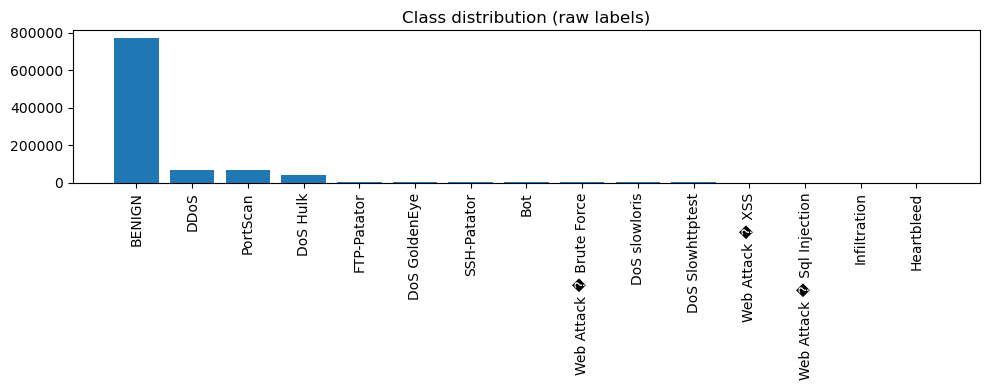

In [3]:
# =====================================
# 3) Label detection & basic class analysis
# =====================================

def find_label_column(columns) -> str | None:
    candidates = ["Label", "label", "Attack", "attack", "Class", "class"]
    for c in candidates:
        if c in columns:
            return c
    lowmap = {c.strip().lower(): c for c in columns}
    for key in ["label", "attack", "class"]:
        if key in lowmap:
            return lowmap[key]
    for c in columns:
        if c.strip().lower().endswith("label"):
            return c
    return None

label_col = find_label_column(df_raw.columns)
if label_col is None:
    raise ValueError(f"Target column not found. Available columns: {df_raw.columns.tolist()}")

print("Detected label column:", repr(label_col))

df = df_raw.copy()
df[label_col] = (
    df[label_col]
      .astype(str)
      .str.replace("\xa0", " ", regex=False)
      .str.strip()
)

print("Shape:", df.shape)
label_counts = (
    df[label_col]
      .value_counts()
      .rename_axis("label")
      .reset_index(name="count")
)
label_counts["ratio"] = label_counts["count"] / label_counts["count"].sum()
display(label_counts.head(20))

plt.figure(figsize=(10, 4))
plt.bar(label_counts["label"].astype(str), label_counts["count"])
plt.title("Class distribution (raw labels)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Benign samples: 775096
Attack samples: 184904
After benign undersampling:
  Benign: 184904
  Attack: 184904
  Total : 369808


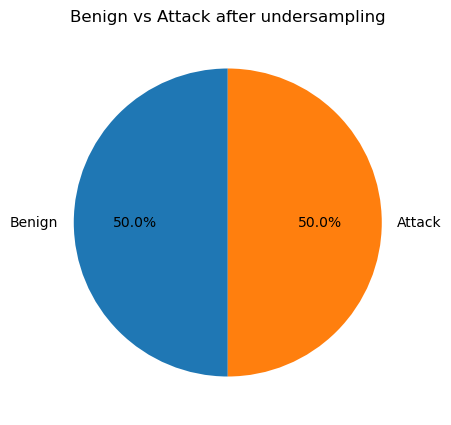

In [4]:
# =====================================
# 4) Benign undersampling to reduce huge class imbalance
# =====================================

is_benign = df[label_col].str.lower().str.contains("benign")
df_benign = df[is_benign].copy()
df_attack = df[~is_benign].copy()

print("Benign samples:", len(df_benign))
print("Attack samples:", len(df_attack))

max_benign_kept = min(len(df_benign), len(df_attack))  # 1:1 ratio
df_benign_sampled = df_benign.sample(
    n=max_benign_kept,
    random_state=RANDOM_STATE
)

df_balanced = pd.concat([df_benign_sampled, df_attack], ignore_index=True)
df_balanced = df_balanced.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

print("After benign undersampling:")
print("  Benign:", (df_balanced[label_col].str.lower().str.contains("benign")).sum())
print("  Attack:", (~df_balanced[label_col].str.lower().str.contains("benign")).sum())
print("  Total :", len(df_balanced))

plt.figure(figsize=(5, 5))
counts_binary = [
    (df_balanced[label_col].str.lower().str.contains("benign")).sum(),
    (~df_balanced[label_col].str.lower().str.contains("benign")).sum(),
]
plt.pie(
    counts_binary,
    labels=["Benign", "Attack"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Benign vs Attack after undersampling")
plt.show()


In [5]:
# =====================================
# 5) Preprocessing & feature cleaning
# =====================================

df_work = df_balanced.copy()

y = df_work[label_col].astype(str).str.strip()
X = df_work.drop(columns=[label_col])

for c in X.columns:
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="coerce")

X = X.replace([np.inf, -np.inf], np.nan)

dropped = {"identifiers": [], "duplicates": [], "too_missing": [], "near_constant": [], "high_corr": []}

id_like = [c for c in ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Fwd Header Length.1"] if c in X.columns]
if id_like:
    dropped["identifiers"].extend(id_like)
    X = X.drop(columns=id_like)

duplicated_names = X.columns[X.columns.duplicated()].tolist()
if duplicated_names:
    dropped["duplicates"].extend(duplicated_names)
    X = X.loc[:, ~X.columns.duplicated()]

missing_ratio = X.isna().mean()
too_missing = missing_ratio[missing_ratio > 0.30].index.tolist()
if too_missing:
    dropped["too_missing"].extend(too_missing)
    X = X.drop(columns=too_missing)

num_cols_tmp = X.select_dtypes(include=[np.number]).columns
stds = X[num_cols_tmp].std()
near_const = stds[stds < 1e-8].index.tolist()
if near_const:
    dropped["near_constant"].extend(near_const)
    X = X.drop(columns=near_const)

num_cols_tmp = X.select_dtypes(include=[np.number]).columns
corr = X[num_cols_tmp].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.98)]
if to_drop_corr:
    dropped["high_corr"].extend(to_drop_corr)
    X = X.drop(columns=to_drop_corr)

def _print_drop_group(title, cols):
    print(f"{title} ({len(cols)})")
    if cols:
        display(pd.DataFrame({"dropped_columns": sorted(cols)}))

print("=== Feature pruning report ===")
_print_drop_group("Identifiers / metadata", dropped["identifiers"])
_print_drop_group("Duplicated columns", dropped["duplicates"])
_print_drop_group("Too many missing (>30%)", dropped["too_missing"])
_print_drop_group("Near-constant std", dropped["near_constant"])
_print_drop_group("High correlation (>0.98)", dropped["high_corr"])

X_clean = X.copy()
y_clean = y.copy()

num_cols = X_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_clean.columns if c not in num_cols]

print("Final feature matrix shape:", X_clean.shape)
print("Numeric features:", len(num_cols), "| Categorical features:", len(cat_cols))

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols),
    ],
    remainder="drop",
)

# Filtrer les classes trop rares pour permettre une stratification correcte
class_counts = y_clean.value_counts()
valid_classes = class_counts[class_counts >= 2].index  # >= 2 échantillons par classe

X_clean_strat = X_clean[y_clean.isin(valid_classes)]
y_clean_strat = y_clean[y_clean.isin(valid_classes)]

print("Class distribution after filtering rare classes:")
print(y_clean_strat.value_counts())
print("Shapes after filtering:", X_clean_strat.shape, "labels:", y_clean_strat.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_clean_strat, y_clean_strat,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y_clean_strat,
)
# ================================

print("Train:", X_train.shape, "Test:", X_test.shape)


=== Feature pruning report ===
Identifiers / metadata (1)


,dropped_columns
0,Fwd Header Length.1


Duplicated columns (0)
Too many missing (>30%) (0)
Near-constant std (8)


,dropped_columns
0,Bwd Avg Bulk Rate
1,Bwd Avg Bytes/Bulk
2,Bwd Avg Packets/Bulk
3,Bwd PSH Flags
4,Bwd URG Flags
5,Fwd Avg Bulk Rate
6,Fwd Avg Bytes/Bulk
7,Fwd Avg Packets/Bulk


High correlation (>0.98) (20)


,dropped_columns
0,Bwd Packet Length Mean
1,Bwd Packet Length Std
2,Fwd IAT Max
3,Fwd IAT Total
4,Fwd Packet Length Mean
5,Fwd Packets/s
6,Fwd URG Flags
7,Idle Max
8,Idle Mean
9,Idle Min


Final feature matrix shape: (369808, 49)
Numeric features: 49 | Categorical features: 0
Class distribution after filtering rare classes:
Label
BENIGN                        184904
DDoS                           68025
PortScan                       66709
DoS Hulk                       40014
FTP-Patator                     2121
DoS GoldenEye                   1796
SSH-Patator                     1588
Bot                             1231
Web Attack � Brute Force        1028
DoS slowloris                   1007
DoS Slowhttptest                 903
Web Attack � XSS                 454
Web Attack � Sql Injection        15
Infiltration                      12
Name: count, dtype: int64
Shapes after filtering: (369807, 49) labels: (369807,)
Train: (258864, 49) Test: (110943, 49)


In [6]:
# =====================================
# 6) Problem definition & helper functions
# =====================================

TASK = "binary"  # or "multiclass"

def make_classification_targets(y_train_raw: pd.Series, y_test_raw: pd.Series):
    y_train_use = y_train_raw.copy()
    y_test_use = y_test_raw.copy()
    if TASK == "binary":
        y_train_use = y_train_use.apply(lambda v: "Benign" if "benign" in str(v).strip().lower() else "Attack")
        y_test_use = y_test_use.apply(lambda v: "Benign" if "benign" in str(v).strip().lower() else "Attack")
    return y_train_use, y_test_use

def feature_names_from_ct(ct: ColumnTransformer, input_df: pd.DataFrame):
    num_cols_ct = ct.transformers_[0][2] if len(ct.transformers_) > 0 else []
    cat_cols_ct = ct.transformers_[1][2] if len(ct.transformers_) > 1 else []
    return list(num_cols_ct) + list(cat_cols_ct)

def show_top_features(pipe: Pipeline, feat_names, k: int = 20):
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "coef_"):
        coef = np.abs(clf.coef_)
        imp = coef.mean(axis=0) if coef.ndim == 2 else np.abs(coef)
        idx = np.argsort(imp)[::-1][:min(k, len(imp))]
        top = pd.DataFrame({"feature": np.array(feat_names)[idx], "importance": imp[idx]})
        display(top.reset_index(drop=True))
    elif hasattr(clf, "feature_importances_"):
        imp = clf.feature_importances_
        idx = np.argsort(imp)[::-1][:min(k, len(imp))]
        top = pd.DataFrame({"feature": np.array(feat_names)[idx], "importance": imp[idx]})
        display(top.reset_index(drop=True))
    else:
        print("No feature importance available for this model.")

def try_macro_roc_auc(pipeline: Pipeline, X_te, y_te):
    try:
        proba = pipeline.predict_proba(X_te)
        if TASK == "binary":
            y_bin = (y_te != "Benign").astype(int)
            classes_ = pipeline.classes_
            pos_idx = list(classes_).index("Attack") if "Attack" in classes_ else 1
            roc = roc_auc_score(y_bin, proba[:, pos_idx])
            print(f"ROC AUC (binary): {roc:.4f}")
        else:
            classes_ = pipeline.classes_
            y_bin = label_binarize(y_te, classes=classes_)
            roc_macro = roc_auc_score(y_bin, proba, average="macro", multi_class="ovr")
            print(f"ROC AUC macro (multiclass): {roc_macro:.4f}")
    except Exception:
        print("ROC AUC not available.")

y_train_use, y_test_use = make_classification_targets(y_train, y_test)
print("TASK:", TASK)
print("Train classes:", y_train_use.value_counts())


TASK: binary
Train classes: Label
Attack    129432
Benign    129432
Name: count, dtype: int64


In [7]:
# =====================================
# 7) Baseline models with cross-validation
# =====================================

def make_calibrated_linear_svc():
    try:
        return CalibratedClassifierCV(
            estimator=LinearSVC(class_weight="balanced"),
            method="sigmoid",
            cv=2,
        )
    except TypeError:
        return CalibratedClassifierCV(
            estimator=LinearSVC(class_weight="balanced"),
            method="sigmoid",
        )

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
    ),
    "LinearSVC": make_calibrated_linear_svc(),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=RANDOM_STATE,
    ),
}

if XGBOOST_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        max_depth=6,
        n_estimators=250,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_rows = []
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    scores = cross_validate(
        pipe,
        X_train,
        y_train_use,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )
    row = {"model": name}
    for metric in scoring.keys():
        row[f"cv_{metric}_mean"] = scores[f"test_{metric}"].mean()
        row[f"cv_{metric}_std"] = scores[f"test_{metric}"].std()
    cv_rows.append(row)

cv_df = pd.DataFrame(cv_rows).sort_values("cv_f1_macro_mean", ascending=False).reset_index(drop=True)
display(cv_df)

best_name = cv_df.iloc[0]["model"]
print("Selected baseline model:", best_name)
best_clf = models[best_name]


,model,cv_accuracy_mean,cv_accuracy_std,cv_precision_macro_mean,cv_precision_macro_std,cv_recall_macro_mean,cv_recall_macro_std,cv_f1_macro_mean,cv_f1_macro_std
0,RandomForest,0.998486,0.000209,0.998486,0.000209,0.998486,0.000209,0.998486,0.000209
1,GradientBoosting,0.994221,0.000580,0.994226,0.000579,0.994221,0.000580,0.994221,0.000580
2,LogisticRegression,0.932103,0.005046,0.933203,0.004605,0.932103,0.005046,0.932059,0.005065
3,LinearSVC,0.927251,0.003858,0.928492,0.003656,0.927251,0.003858,0.927198,0.003869


Selected baseline model: RandomForest


=== Test set classification report (baseline) ===


,precision,recall,f1-score,support
Attack,0.998324,0.998648,0.998486,55471.000000
Benign,0.998648,0.998323,0.998485,55472.000000
accuracy,0.998486,0.998486,0.998486,0.998486
macro avg,0.998486,0.998486,0.998486,110943.000000
weighted avg,0.998486,0.998486,0.998486,110943.000000


Accuracy: 0.9985 | Precision_macro: 0.9985 | Recall_macro: 0.9985 | F1_macro: 0.9985


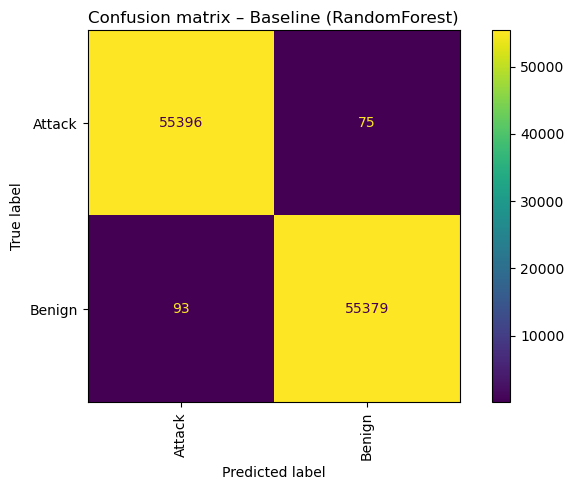

ROC AUC (binary): 0.9997


In [8]:
# =====================================
# 8) Final training of the best baseline & test evaluation
# =====================================

best_pipe = Pipeline([("prep", preprocess), ("clf", best_clf)])
best_pipe.fit(X_train, y_train_use)
y_pred = best_pipe.predict(X_test)

print("=== Test set classification report (baseline) ===")
rep = classification_report(y_test_use, y_pred, output_dict=True, zero_division=0)
display(pd.DataFrame(rep).T)

acc = accuracy_score(y_test_use, y_pred)
prec = precision_score(y_test_use, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test_use, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test_use, y_pred, average="macro", zero_division=0)
print(f"Accuracy: {acc:.4f} | Precision_macro: {prec:.4f} | Recall_macro: {rec:.4f} | F1_macro: {f1:.4f}")

labels_sorted = sorted(pd.unique(y_test_use))
cm = confusion_matrix(y_test_use, y_pred, labels=labels_sorted)
disp = ConfusionMatrixDisplay(cm, display_labels=labels_sorted)
fig = disp.plot(include_values=True, xticks_rotation=90).figure_
fig.set_size_inches(7,5)
plt.title(f"Confusion matrix – Baseline ({best_name})")
plt.tight_layout()
plt.show()

if hasattr(best_pipe.named_steps["clf"], "predict_proba"):
    try_macro_roc_auc(best_pipe, X_test, y_test_use)


In [ ]:
# =====================================
# 9) Hyperparameter tuning of RandomForest with GridSearchCV
# =====================================

rf_base = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

rf_pipe = Pipeline([("prep", preprocess), ("clf", rf_base)])

param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 15, 30],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"],
}

cv_grid = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv_grid,
    n_jobs=-1,
    verbose=2,
)

rf_grid.fit(X_train, y_train_use)

print("Best parameters (GridSearchCV):", rf_grid.best_params_)
print("Best CV macro-F1:", rf_grid.best_score_)

rf_best_pipe = rf_grid.best_estimator_

print("\n=== Tuned RandomForest – Test set performance ===")
y_pred_rf = rf_best_pipe.predict(X_test)
rep_rf = classification_report(y_test_use, y_pred_rf, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_rf).T)

acc_rf = accuracy_score(y_test_use, y_pred_rf)
prec_rf = precision_score(y_test_use, y_pred_rf, average="macro", zero_division=0)
rec_rf = recall_score(y_test_use, y_pred_rf, average="macro", zero_division=0)
f1_rf = f1_score(y_test_use, y_pred_rf, average="macro", zero_division=0)
print(f"Tuned RF – Accuracy: {acc_rf:.4f} | Precision_macro: {prec_rf:.4f} | Recall_macro: {rec_rf:.4f} | F1_macro: {f1_rf:.4f}")

labels_sorted = sorted(pd.unique(y_test_use))
cm_rf = confusion_matrix(y_test_use, y_pred_rf, labels=labels_sorted)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=labels_sorted)
fig = disp_rf.plot(include_values=True, xticks_rotation=90).figure_
fig.set_size_inches(7,5)
plt.title("Confusion matrix – Tuned RandomForest (GridSearchCV)")
plt.tight_layout()
plt.show()

if hasattr(rf_best_pipe.named_steps["clf"], "predict_proba"):
    try_macro_roc_auc(rf_best_pipe, X_test, y_test_use)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [ ]:
# =====================================
# 10) Feature importance & correlation analysis
# =====================================

feat_names = feature_names_from_ct(preprocess, X_train)
show_top_features(rf_best_pipe, feat_names, k=25)

num_cols_corr = df_balanced.select_dtypes(include=[np.number]).columns
corr_matrix = df_balanced[num_cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation heatmap (raw numeric features, undersampled data)")
plt.tight_layout()
plt.show()


In [ ]:
# =====================================
# 11) Save the tuned model
# =====================================

import joblib

best_model = rf_best_pipe
filename = "CICIDS2017_tuned_randomforest_undersampled.joblib"
joblib.dump(best_model, filename)
print("Model saved to:", filename)


## 12) Conclusion

In this notebook we:

- Loaded and merged multiple CICIDS2017 CSV files  
- Strongly reduced the Benign class using undersampling to limit its dominance  
- Built a clean preprocessing pipeline with feature pruning, imputation and scaling  
- Compared several baseline models via stratified cross-validation  
- Performed a GridSearchCV on a RandomForest pipeline to tune key hyperparameters  
- Evaluated both the baseline and the tuned model on a held-out test set  
- Interpreted the tuned model through feature importance and correlation analysis  
